#  Trabajo Práctico 2: Análisis con SVM - Organización de Datos

**Alumnos y Padrón**  
* Grassano, Bruno - 103855  
* Romero, Adrián   - 103371

https://github.com/brunograssano/TP-Organizacion-de-datos

## Importamos las bibiliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from sklearn.svm import SVC

In [4]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeValidacion
from preprocessing import svmPreprocessing

In [5]:
from funcionesAuxiliares import mostrarAUCScore
from funcionesAuxiliares import mostrarROCCurve
from funcionesAuxiliares import mostrarMatrizDeConfusion
from funcionesAuxiliares import escribirPrediccionesAArchivo

## Importamos los datos y los procesamos

In [6]:
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')
X = prepararSetDeDatos(X)
y= prepararSetDeValidacion(y)

In [7]:
X_svm = svmPreprocessing(X)

## Funciones Auxiliares

Creamos una funcion que obtiene mediante grid search y K-Fold cross validation el parametro C y el kernel que maximiza la metrica de AUC_ROC para el modelo de SVM.

In [8]:
def obtenerMejoresParametros(datosPreprocesados):
    mejor_valor = 0
    mejor_c = None
    mejor_kernel = None
    y_array=np.array(y)
    for c in [1,5,10,15,20,25,30,50,75,100,200,300]:
        for kernel in ["poly", "rbf", "linear"]:
            kf = StratifiedKFold(n_splits=5)
            metricas = []
            for fold_idx, (train_index, test_index) in enumerate(kf.split(datosPreprocesados, y_array)):
                svm = SVC(C = c, kernel = kernel, probability = True)
                svm.fit(datosPreprocesados[train_index], y_array[train_index].ravel())
                predicciones = svm.predict_proba(datosPreprocesados[test_index])[:,1]
                score_obtenida = roc_auc_score(y_array[test_index],predicciones)
                metricas.append(score_obtenida)

            if np.mean(metricas) >= mejor_valor:
                mejor_valor = np.mean(metricas)
                mejor_c = c
                mejor_kernel = kernel
            
    return mejor_valor, mejor_c, mejor_kernel

# SVM

SVM es un método de aprendizaje supervisado que busca clasificar instancias a partir de un hiperplano separador de clases. Por lo tanto en principio las instancias deben ser linealmente separables.

Lo que se busca es encontrar un hiperplano que separe las clases y maximice la distancia entre las instancias mas cercanas al mismo, generando asi un margen.

Se dice que el margen es suave o soft cuando se permite que el hiperplano encontrado no separe perfectamente a las clases y que se permitan clasificaciones erroneas en con el objetivo de generalizar mejor. Suele ser útil tener un margen de este tipo cuando hay ruido o outliers.

Cuando las instancias no son linealmente separables se puede recurrir a una transformación de los datos a un espacio de dimensión mayor en el cual sí lo sean. Dado que esto puede ser muy costoso, se suelen utilizar kernels, funciones que permiten calcular las distancias entre instancias en un espacio de dimensión mayor sin realizar la transformación de los datos.

### Dividimos el set de datos en sets de training y test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, y, test_size=0.25, random_state=0)

### Buscamos los mejores parametros

Los parámetros que consideraremos son C y el kernel:

**C:** Es un parámetro de regularización que indica la suavidad del margen generado por el clasificador SVM. Mientras mayor sea C se tiene un margen mas rígido y pequeño que puede ser bueno clasificando los puntos del set de entrenamiento pero generar overfitting. Mientras menor sea C el margen es mas suave en el sentido de que se permiten clasificaciones erróneas sobre el set de entrenamiento con el propósito de generalizar mejor.

**Kernel:** el kernel es la función que calcula el producto interno entre las observaciones en un espacio de dimensión mayor, sin tener que convertir los datos a ese espacio, logrando asi definir una distancia en dimensiones mayores. Consideraremos los kernels: **lineal**, **radial** y **polinomial.** 

In [10]:
mejor_valor, mejor_c, mejor_kernel = obtenerMejoresParametros(X_svm)

In [11]:
print(f"El mejor valor fue de AUC fue: {mejor_valor}")
print(f"El valor de C encontrado que maximiza el AUC fue: {mejor_c}")
print(f"El kernel encontrado que maximiza el AUC fue: {mejor_kernel}")

El mejor valor fue de AUC fue: 0.8546500195514323
El valor de C encontrado que maximiza el AUC fue: 10
El kernel encontrado que maximiza el AUC fue: rbf


Dado que el mejor kernel encontrado fue **rbf** buscamos un optimizar un nuevo hiperparámetro: 

$\gamma$, es un parametro que se utiliza en este kernel y que indica cuanta influencia tiene cada instancia de entrenamiento. Este parámetro influencia en el calculo de la distancia entre las instancias. 

In [12]:
def obtenerMejorGamma(datosPreprocesados, mejor_c, mejor_kernel):
    mejor_gamma = None
    mejor_valor = 0
    y_array=np.array(y)
    for gamma in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        kf = StratifiedKFold(n_splits=5)
        metricas = []
        for fold_idx, (train_index, test_index) in enumerate(kf.split(datosPreprocesados, y_array)):
            svm = SVC(C = mejor_c, kernel = mejor_kernel, gamma=gamma,probability = True)
            svm.fit(datosPreprocesados[train_index], y_array[train_index].ravel())
            predicciones = svm.predict_proba(datosPreprocesados[test_index])[:,1]
            score_obtenida = roc_auc_score(y_array[test_index],predicciones)
            metricas.append(score_obtenida)

        if np.mean(metricas) >= mejor_valor:
            mejor_valor = np.mean(metricas)
            mejor_gamma = gamma
            
    return mejor_valor, mejor_gamma

In [13]:
mejor_valor, mejor_gamma = obtenerMejorGamma(X_svm, mejor_c, mejor_kernel)

In [21]:
print(f"El mejor valor fue de AUC fue: {round(mejor_valor,3)}")
print(f"El valor de gamma encontrado que maximiza el AUC fue: {mejor_gamma}")

El mejor valor fue de AUC fue: 0.856
El valor de gamma encontrado que maximiza el AUC fue: 0.1


### Evaluamos las metricas

In [15]:
svm = SVC(C=mejor_c, kernel=mejor_kernel, gamma=mejor_gamma,probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.85      0.85      0.85       121
      Vuelve       0.78      0.78      0.78        80

    accuracy                           0.82       201
   macro avg       0.81      0.81      0.81       201
weighted avg       0.82      0.82      0.82       201



C:\Users\Bruno\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Observamos que tiene un 82% de accuracy lo cual esta en el mismo orden de los otros modelos con esta metrica.

### Matriz de confusion

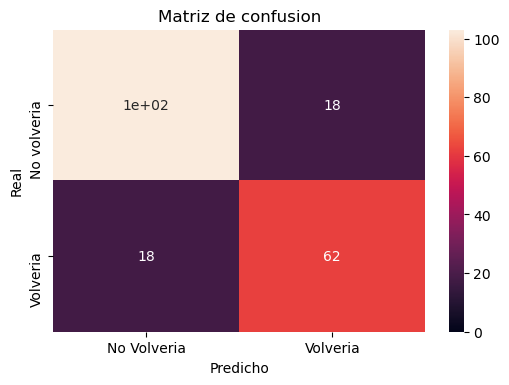

In [16]:
mostrarMatrizDeConfusion(y_pred,y_test)

Respecto de la matriz de confusión corroborar nuevamente que la clasificación tiene un buen accuracy, pues los valores en la diagonal principal son mucho mayores que los de la diagonal invertida.  

Por otro lado pareciera tener una cantidad similar de falsos positivos y de falsos negativos

### Graficamos la curva ROC

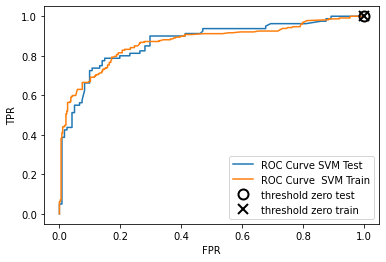

In [17]:
mostrarROCCurve(svm,"SVM",X_test, X_train, y_test, y_train)

In [18]:
mostrarAUCScore(svm,"SVM",X_test,y_test)

AUC para SVM: 0.871


## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento realizado anteriormente.

In [20]:
holdout = pd.read_csv('Datasets/tp-2020-2c-holdout-cols2.csv')

holdout = prepararSetDeDatos(holdout)
holdout_svm = svmPreprocessing(holdout)

Realizamos las predicciones y escribimos al archivo CSV.

In [ ]:
#predicciones_holdout = rl.predict(holdout_svm)

In [ ]:
#predicciones_holdout

In [ ]:
#escribirPrediccionesAArchivo(predicciones_holdout,"SVM")